# Introduction and demonstration of OSTL

This tutorial starts from a short description of BPTT, followed by a discussion of its shortcomings. Next, we introduce OSTL as a biologically-inspired alternative to BPTT. We demonstrate its basic operational principle and showcase the gradient-equivalence for certain scenarios, using here an example of a simple task of learning the XOR function. In particular, this tutorial:

1. Introduces Online Spatio-Temporal Learning (OSTL) as an alternative to back-propagation through time (BPTT)
2. Illustrates the basic working principle of OSTL
3. Demonstrates gradient-equivalence for LSTM and bio-inspired SNU units

This tutorial is based on the paper
**Bohnstingl, T., Woźniak, S., Maass, W., Pantazi, A., & Eleftheriou, E. (2020). Online Spatio-Temporal Learning in Deep Neural Networks. arXiv, 2007.12723. https://arxiv.org/abs/2007.12723v2**

## Back-propagation through time (BPTT)

Almost all recurrent neural networks (RNN) used in machine learning operating on temporal input data are trained with the error back-propagation through time algorithm. This algorithm works by unrolling the RNN over time, i.e., the network is replicated for each individual discrete time step. The video below illustrates this process for a two-layer RNN which receives a phrase of French words as an input sequence: "Conseil Européen pour la Recherche Nucléaire", and is given the task to translate this three-step long sentence into its English version: "European Council for Nuclear Research".

![](./Figures/BPTT.gif)
    
At first, the network is unrolled in time, i.e., the network is replicated for three time steps. Then, the inputs for these time steps are fed sequentially and the output is computed for each time step separately. Once the entire input sequence has been processed, the network operation is interrupted and the gradients of the error with respect to the parameters are propagated back through time. 

$$
\newcommand{\dv}[2]{\frac{\textrm{d}#1}{\textrm{d}#2}}
\newcommand{\pdv}[2]{\frac{\partial #1}{\partial #2}}
\begin{align}
\Delta {\theta}_l &= -\eta \dv{E}{{\theta}_l}\\
&= -\eta \sum_{1 \leq t \leq T} \dv{E_k^t}{{\theta}_l}
\end{align}$$

It is important to note that the error is typically only provided at the output layer *k* and has to propagate through the units in the network to reach all parameters. For example, if a network is composed of two layers with simple RNN cells:

$$
\newcommand{\dv}[2]{\frac{\textrm{d}#1}{\textrm{d}#2}}
\newcommand{\pdv}[2]{\frac{\partial #1}{\partial #2}}
\begin{align}
{s}_l^t &= g({W}_l x^t + {H}_l y^t + d \cdot (1- y_l^{t-1}) \cdot {s}_l^{t-1}),\\
{y}_l^t &= {\sigma}({s}^t + {b}_l),
\end{align}$$

with $${\theta}_l=\{{W}_l, {H}_l, {b}_l\}$$.
    
### Disadvantages and drawbacks
- In order to compute $\Delta {\theta}_l$, the input sequence has to be observed till its last time step and the intermediate activations need to be stored
- In consequence, memory requirements grow linearly with length of input sequence *T*
- Separate phases for the forward propagation and the gradient computation are required 
- $\Delta {\theta}_l$ contains a complex combination of *spatial* and *temporal* gradients 

## Online Spatio-Temporal Learning (OSTL)

A way to tackle the shortcomings of BPTT is proposed in OSTL. This algorithm also makes use of gradient computations, but the way those computations are done is much inspired by findings from biological systems.
In particular, as the following Figure illustrates, three factors are found in biology to modulate the change of synaptic weights (plasticity):
1. Pre-synaptic activity
2. Post-synaptic activity
3. Learning signals, so called-third factors

![](./Figures/ThreeFactors.svg)

Inspired by this, we assign to each synapse a so-called eligibility trace
$$
\newcommand{\dv}[2]{\frac{\textrm{d}#1}{\textrm{d}#2}}
\newcommand{\pdv}[2]{\frac{\partial #1}{\partial #2}}
\begin{align}
\mathbf{e}^{t,{\theta}_l}_{k} &= \pdv{{y}^t_{k}}{{s}^t_{k}} {\epsilon}^{t,{\theta}_l}_{k} + \pdv{{y}^t_{k}}{{\theta}_{l}},
\end{align}$$

with $$
\newcommand{\dv}[2]{\frac{\textrm{d}#1}{\textrm{d}#2}}
\newcommand{\pdv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand\myeq{\stackrel{\mbox{def}}{=}}
\begin{align}
{\epsilon}_k^{t,{\theta}_l} &\myeq \dv{{s}_k^t}{{\theta}_l}.
\end{align}$$

Importantly, this eligibility trace holds information of the pre- and post-synaptic activity and carries this information through time, hence those are the spatial gradient components. Furthermoer, we define the learning signal, which transports information from the environment to the synapses, to be
$$
\newcommand{\dv}[2]{\frac{\textrm{d}#1}{\textrm{d}#2}}
\newcommand{\pdv}[2]{\frac{\partial #1}{\partial #2}}
\begin{align}
\mathbf{L}^t_{l} &= \pdv{E^t}{{y}_k^t} \left( \prod_{(k-l+1) > m \ge 1} \pdv{{y}^t_{k-m+1}}{{s}^t_{k-m+1}} \pdv{{s}^t_{k-m+1}}{{y}^t_{k-m}} \right).
\end{align}$$

The learning signal transports information from the environment to the individual layers of the network *l*, hence those are the temporal components of the gradients. 
To finally compute the gradients for the trainable parameters, the eligitbility traces and the learning signals are combined at each time step (online) according to
$$
\newcommand{\dv}[2]{\frac{\textrm{d}#1}{\textrm{d}#2}}
\newcommand{\pdv}[2]{\frac{\partial #1}{\partial #2}}
\begin{align}
\Delta {\theta}_l &= -\eta \sum_{1 \leq t \leq T} \left( \mathbf{L}_l^t \mathbf{e}_l^{t,{\theta}_l} + \mathbf{R}\right),
\end{align}
$$

which gives rise to the name "Online Spatio-Temporal learning".
The working pricinple of OSTL is illustrated in the animation below.

![](./Figures/OSTL.gif)

## Implementation

We start by importing required python packages and by defining an auxiliary function for data generation.

In [1]:
#General imports
import collections
import argparse
import time
import pickle
import Scripts.Utils_Persistence as Utils_Persistence
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import rnn_cell_impl
    
#This function creates data from the XOR function
def createXorData(bs, seq_len):
    x_val = np.tile(np.expand_dims([[1], [0], [1], [1], [0], [0], [1], [1], [0], [1]], 0), (bs, 1, 1))
    y_val = np.tile(np.expand_dims([[0], [1], [1], [1], [0], [0], [0], [0], [1], [0]], 0), (bs, 1, 1))
    
    return x_val, y_val

C:\Users\ThomasBohnstingl\.conda\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ThomasBohnstingl\.conda\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ThomasBohnstingl\.conda\envs\TF\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ThomasBohnstingl\.conda\envs\TF\lib\site-packages

In [2]:
#OSTL specific inputs
from Scripts.RNN_loop import dynamic_rnn
from Scripts.MultiRNNCell import MultiRNNCell
from Scripts.gradient_descent import GradientDescentOptimizer as opt
from Scripts.Neuron_models import SNUELayer

### Define configuration of the network

In this section, the network configuration is defined. For example, the type of unit to run may be selected. One of the options is to use soft spiking neural units (sSNU). These units have been introduced in the paper **Woźniak, S., Pantazi, A., Bohnstingl, T., & Eleftheriou, E. (2020). Deep learning incorporating biologically inspired neural dynamics and in-memory computing - Nature Machine Intelligence. Nat. Mach. Intell., 2(6), 325–336. doi: 10.1038/s42256-020-0187-0**

In [3]:
config = {'lr': 0.01,
          'batch_size': 1,
          'cell': 'sSNU',
          'seq_len': 10,
          'save_state': True,
         }

As the first step, we generate the data that will later be used for training and for testing. This tutorial illustrates solving a fixed input/output relation using the sSNU. The following animation demonstrates this task: 

![](XOR2.gif)

In [4]:
#Fix the random seed in order to be able to numerically 
#compare the computed gradients
np.random.seed(1234)
tf.set_random_seed(1234)

#We generate "config['batch_size']" examples with a length of 100 for testing 
val_data_x_val, val_data_y_val = createXorData(config['batch_size'], config['seq_len'])

#We generate data roughly 2000 examples with a length of 100 for traininging
train_data_x_val, train_data_y_val = createXorData(int(2000/config['batch_size']), config['seq_len'])
train_data_x_val.shape

#Generate test data
test_data_x_val, test_data_y_val = createXorData(config['batch_size'], config['seq_len'])

Next we can also briefly visualize the data

In [5]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
from matplotlib import patches
from matplotlib import cm
matplotlib.rcParams.update({'font.size': 22})

C:\Users\ThomasBohnstingl\.conda\envs\TF\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


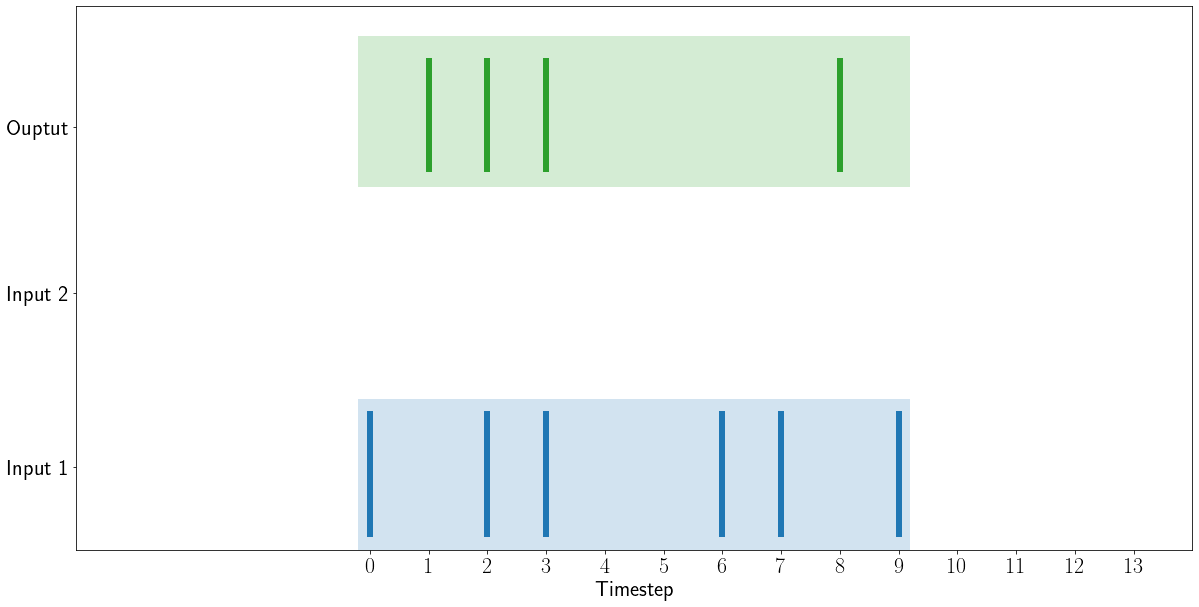

In [6]:
fig, ax = plt.subplots(1, 1)
for x in np.where(train_data_x_val[10, :20, 0])[0]:
    ax.axvline(x=x, ymin=0.03, ymax=0.25, color='C0', linewidth=6.)
p = patches.Rectangle((-0.2, -0.1), 0.4+np.max(np.where(train_data_x_val[10, :20, :])[0]), 1, linewidth=1, edgecolor='none', facecolor='C0', alpha=0.2)
ax.add_patch(p)
for x in np.where(train_data_y_val[10, :20, 0])[0]:
    ax.axvline(x=x, ymin=0.7, ymax=0.9, color='C2', linewidth=6.)
p = patches.Rectangle((-0.2, 2.3), 0.4+np.max(np.where(train_data_x_val[10, :20, :])[0]), 1, linewidth=1, edgecolor='none', facecolor='C2', alpha=0.2)
ax.add_patch(p)

ax.set_xlim([-5., np.max(np.where(train_data_x_val[10, :20, :])[0])+5.])
ax.set_xticks(np.arange(0., np.max(np.where(train_data_x_val[10, :20, :])[0])+5.))
ax.set_xlabel('Timestep')
ax.set_ylim([-0.1,3.5])
ax.set_yticklabels(['Input 1', 'Input 2', 'Ouptut'])
ax.set_yticks([0.45, 1.6, 2.7])

### Preparation of the network architecture

<Put an illustration of the network architecture here>

Let's define some placeholders

In [7]:
#Define the placeholders to construct the network
x = tf.placeholder(tf.float32, [None, None, 1])  #(batchsize, timesteps, number of units)
target = tf.placeholder(tf.float32, [None, None, 1])
train = tf.placeholder_with_default(tf.constant(1, tf.int32), ())

Let's define the units to be used

In [8]:
#List containing the RNN units
rnn_layers_BPTT = []
rnn_layers_OSTL = []

#Create fixed random initializers for reproducibility
initW = np.random.uniform(-np.sqrt(6) / np.sqrt(1 + 1), np.sqrt(6) / np.sqrt(1 + 1), size=(1, 1))
initH = np.random.uniform(-np.sqrt(6) / np.sqrt(1 + 1), np.sqrt(6) / np.sqrt(1 + 1), size=(1, 1))

#Create the SNU layer for BPTT and for OSTL
rnn_layers_BPTT.append(SNUELayer(1, 1, activation=tf.nn.sigmoid, recurrent=True, decay=0., g=tf.identity, initW=initW, initH=initH, name='BPTT'))
rnn_layers_OSTL.append(SNUELayer(1, 1, activation=tf.nn.sigmoid, recurrent=True, decay=0., g=tf.identity, initW=initW, initH=initH, name='OSTL'))
'''
#Create the SNU layer for BPTT and for OSTL
rnn_layers_BPTT.append(SNUELayer(1, 1, activation=tf.nn.sigmoid, recurrent=True, decay=0., g=tf.identity, name='BPTT'))
rnn_layers_OSTL.append(SNUELayer(1, 1, activation=tf.nn.sigmoid, recurrent=True, decay=0., g=tf.identity, name='OSTL'))
'''

"\n#Create the SNU layer for BPTT and for OSTL\nrnn_layers_BPTT.append(SNUELayer(1, 1, activation=tf.nn.sigmoid, recurrent=True, decay=0., g=tf.identity, name='BPTT'))\nrnn_layers_OSTL.append(SNUELayer(1, 1, activation=tf.nn.sigmoid, recurrent=True, decay=0., g=tf.identity, name='OSTL'))\n"

Define the optimizer to be used

In [9]:
optimizer = opt(learning_rate=config['lr'])

Next, we define the loss function and the optimization step

In [10]:
#Define the loss function to be used in OSTL
def loss_function(target_t, output_t, time, layer):
    '''
    Computes the desired loss for a single timestep
    '''
    loss = tf.reduce_sum(tf.cast(tf.squared_difference(output_t, target_t), dtype=tf.float32))
    loss = tf.reduce_sum(loss)
    return loss

#Define the gradient function to compute the learning signal
def gradient_function(loss, output_t, time, last_time, layer):
    '''
    Computes the learning signal used for OSTL
    '''
    grads = tf.gradients(loss, output_t)[0]
    return grads

#Optimization step for BPTT
multi_rnn_cell_BPTT = tf.nn.rnn_cell.MultiRNNCell(rnn_layers_BPTT)
out_BPTT, state_BPTT = tf.nn.dynamic_rnn(multi_rnn_cell_BPTT, x, dtype=tf.float32)
loss_BPTT = loss_function(target, out_BPTT, None, 0)
train_step_BPTT = optimizer.minimize(loss_BPTT)

#Optimization step for OSTL
multi_rnn_cell_OSTL = MultiRNNCell(rnn_layers_OSTL)
out_OSTL, state_OSTL = dynamic_rnn(multi_rnn_cell_OSTL, x, target, loss_function, gradient_function, train, 1, 0, -1, optimizer, dtype=tf.float32)
loss_OSTL = loss_function(target, out_OSTL, None, 0)
train_step_OSTL = tf.no_op()

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


### Train the network

In [11]:
#Array to track the gradients of the individual weights
vals_BPTT = []
vals_OSTL = []

vals_tensor_length = int(len(tf.trainable_variables())/2)
vals_tensor_BPTT = tf.trainable_variables()[:vals_tensor_length]
vals_tensor_OSTL = tf.trainable_variables()[vals_tensor_length:]

#Define the feed_dictionary for testing
feed_dict_val = {x: val_data_x_val,
                 target: val_data_y_val,
                 train: 0.}

#Define a TF session
s = tf.Session()

#Run the initialization of the network
s.run(tf.global_variables_initializer())

#Store the initial weights of the network
init_weights_BPTT = s.run(vals_tensor_BPTT)
init_weights_OSTL = s.run(vals_tensor_OSTL)

#Iterate over the training data
iterations = int(2000/config['batch_size'])

#Try to load a checkpoint if any exists
resume = Utils_Persistence.LoadObject('./checkpoints/GradEqu_' + config['cell'])
if resume is not None:
    print('Loading checkpoint')
    itrStart = resume['itr']
    np.random.set_state(resume['rng'])
    Utils_Persistence.PersistenceLoadThis(s, 'GradEqu_' + config['cell'] + '_e' + str(itrStart), withGraph=False)
    if itrStart >= iterations:
        print("State loaded: already finished training at itr", itrStart, ". Plotting & exiting.")
        exit(0)
    else:
        print('State loaded: resuming the learning from itr', itrStart)
    not_loaded = False
else:
    print("Did not find checkpoint. Run from scratch")
    itrStart = 0
    not_loaded = True

for itr in range(itrStart, iterations):

    #Define the feed dictionary for training
    feed_dict = {x: train_data_x_val[(config['batch_size']*itr):(config['batch_size']*(itr+1)), :],
                 target: train_data_y_val[(config['batch_size']*itr):(config['batch_size']*(itr+1)), :],
                 train: 1.}
    
    #Run a single training step
    o_BPTT, o_OSTL, _, _ = s.run([out_BPTT, out_OSTL, train_step_BPTT, train_step_OSTL], feed_dict=feed_dict)

    #Store the intermediate values of the parameters
    vals_BPTT.append(s.run(vals_tensor_BPTT))
    vals_OSTL.append(s.run(vals_tensor_OSTL))
    
    #Evaluate the model on the testset every 100 iterations
    if itr % 100 == 0:
        l_BPTT, l_OSTL = s.run([loss_BPTT, loss_OSTL], feed_dict=feed_dict_val)
        print('(' + str(itr + 100) + '/' + str(iterations) + ') Loss (BPTT): ' + str(l_BPTT) + ', Loss (OSTL): ' + str(l_OSTL))
      
vals_BPTT.append(s.run(vals_tensor_BPTT))
vals_OSTL.append(s.run(vals_tensor_OSTL))
    
#Save the final checkpoint
if not_loaded and 'GradEqu_' + config['cell'] is not None and config['save_state']:
    Utils_Persistence.PersitenceSaveThis(s, 'GradEqu_' + config['cell'] + '_e' + str(itr))
    Utils_Persistence.SaveObject({'itr': itr, 'rng': np.random.get_state(),
                                  'vals_BPTT': vals_BPTT, 'vals_OSTL': vals_OSTL},
                                  './checkpoints/GradEqu_' + config['cell'])    
    print('State saved at iteration ' + str(itr))

Loading checkpoint
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoints/GradEqu_sSNU_e1999
State loaded: resuming the learning from itr 1999


### Evaluate the network

Load stored checkpoints

In [12]:
#Try to load a checkpoint if any exists
resume = Utils_Persistence.LoadObject('./checkpoints/GradEqu_' + config['cell'])
if resume is not None:
    print('Loading checkpoint')
    itrStart = resume['itr']
    vals_BPTT = resume['vals_BPTT']
    vals_OSTL = resume['vals_OSTL']
    np.random.set_state(resume['rng'])
    Utils_Persistence.PersistenceLoadThis(s, 'GradEqu_' + config['cell'] + '_e' + str(itrStart), withGraph=False)
    print('State loaded: resuming the learning from itr', itrStart)
else:
    print("Did not find checkpoint. Please run model from scratch!")

Loading checkpoint
INFO:tensorflow:Restoring parameters from ./checkpoints/GradEqu_sSNU_e1999
State loaded: resuming the learning from itr 1999


After the model has been trained for a while, the model can be tested on unseed data

In [13]:
print('Demo XOR data')
print('Input: ' + str(test_data_x_val[0, :, 0].flatten().astype(np.int32)) + '\n')
print('Ouput: ' + str(test_data_y_val[0, :, 0].flatten()))

#Create the new feed_dict
feed_dict_test = {x: test_data_x_val,
                  target: test_data_y_val,
                  train: 0.}
o_BPTT, o_OSTL = s.run([out_BPTT, out_OSTL], feed_dict=feed_dict_test)
print('BPTT:  ' + str((o_BPTT[0] > 0.5).astype(np.int32).flatten()) + '\nOSTL:  ' + str((o_OSTL[0] > 0.5).astype(np.int32).flatten()))

Demo XOR data
Input: [1 0 1 1 0 0 1 1 0 1]

Ouput: [0 1 1 1 0 0 0 0 1 0]
BPTT:  [0 1 0 0 1 1 0 0 1 0]
OSTL:  [0 1 0 0 1 1 0 0 1 0]


### Investigate the gradients

In this simple scenario of a single-layered RNN, it can be shown that the gradients of OSTL and BPTT are equivalent. This is empirically demonstrated below. First, a random element of the input weights is selected and then analyzed.

In [14]:
#Pick randomly entries from the gradients for each trainable parameter
param_ind = []
for param in tf.trainable_variables()[:vals_tensor_length]:
    param_ind.append(np.random.randint(0, int(np.prod(param.shape))))

The figure below illustrates the evolution of the learning signal and of the eligibility trace. Those two quantities combined together form the gradient updates for the parameters. One can see in the third panel that the gradient updates of BPTT and of OSTL align.

![](learn_el.svg)

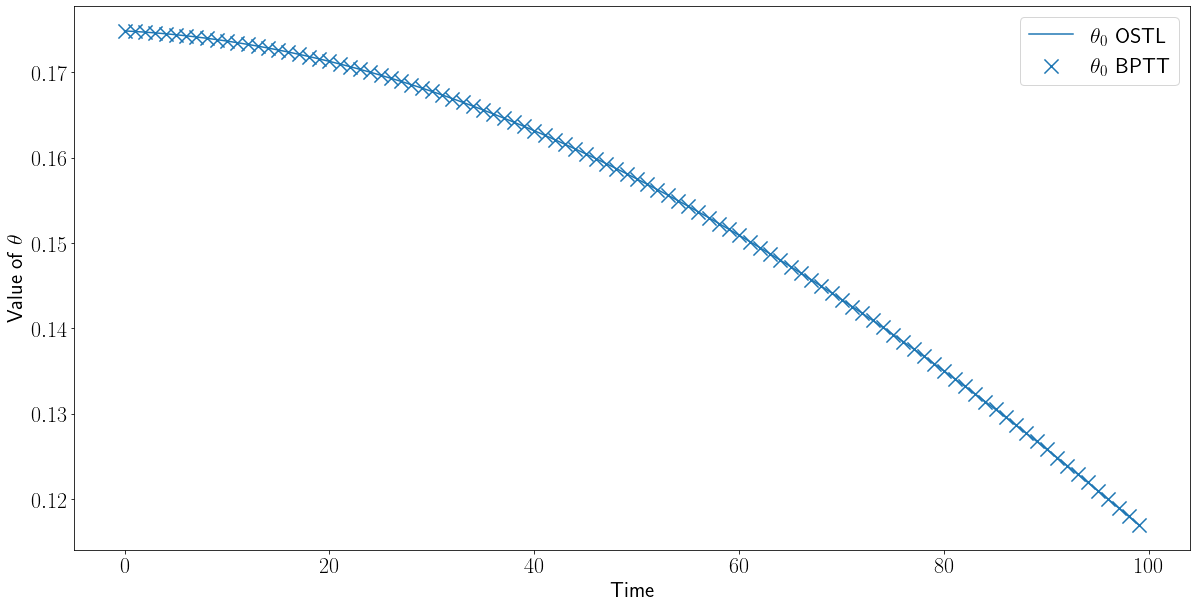

In [15]:
fig, ax = plt.subplots(1, 1)
for ind, param in enumerate(tf.trainable_variables()[:1]):
    data_BPTT = [p.flatten()[param_ind[ind]] for p in [g[ind] for g in vals_BPTT]][:100]
    data_OSTL = [p.flatten()[param_ind[ind]] for p in [g[ind] for g in vals_OSTL]][:100]
    line = ax.plot(np.arange(len(data_OSTL)), data_OSTL, label=r'$\theta_' + str(ind) + '$ OSTL')
    ax.scatter(np.arange(len(data_BPTT)), data_BPTT, marker='x', s=200., color=line[0].get_color(), label=r'$\theta_' + str(ind) + '$ BPTT')
ax.set_ylabel(r'Value of $\theta$')
ax.set_xlabel('Time')
ax.legend()